# if you like it ,please vote for it,good score for you ( •̀ ω •́ )✧

V1: seresnet101 0.959

V6: B7+InceprtionresnetV2 0.974

V7: image_size=800 0.974

V8:replace optimizer 0.978

V9:weight=noisy-student,

V10:5 K-fold+SoftProbField

In [1]:
!pip install -q efficientnet

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# TPU Config

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 40
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Load Labels

In [4]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

In [5]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

train_paths = train.image_id.apply(format_path).values
test_paths = test.image_id.apply(format_path).values

train_labels = train.loc[:, 'healthy':].values

## если планируете обучать модель с валидирующим набором данных
# train_paths, valid_paths, train_labels, valid_labels = train_test_split(
#     train_paths, train_labels, test_size=0.15, random_state=2020)

# Image Resizing

In [6]:
image_size = 850

In [7]:
def decode_image(filename, label=None, image_size=(image_size, image_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [8]:
train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
train_dataset_1 = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(64)
    .prefetch(AUTO)
)
# valid_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((valid_paths, valid_labels))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .cache()
#     .prefetch(AUTO)
# )

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Learning rate schedule: 0.0001 to 0.0004 to 0.0001


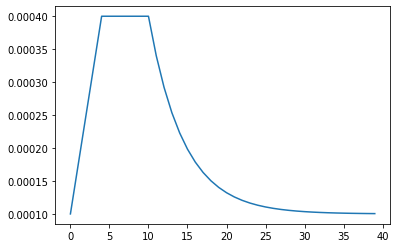

In [9]:
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
from tensorflow.keras.layers import Layer

class SoftProbField(Layer):
    def __init__(self, **kwargs):
        super(SoftProbField, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SoftProbField, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        h = x[:, 0]
        s = x[:, 1]
        r = x[:, 2]
        
        m = s*r*(1-h)
        s = s*(1-h)*(1-m)
        r = r*(1-h)*(1-m)
        return tf.stack([h, m, r, s], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4)

# Model Architecture

In [11]:
with strategy.scope():
    model = tf.keras.Sequential([
        InceptionResNetV2(
            input_shape=(image_size, image_size, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(3, activation='sigmoid'),
        SoftProbField()
    ])
        
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

219062272/219055592 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 25, 25, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
_________________________________________________________________
soft_prob_field (SoftProbFie (None, 4)                 0         
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________


In [12]:

STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=valid_dataset
)

Train for 14 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
14/14 [==============================] - 306s 22s/step - loss: 1.0425 - categorical_accuracy: 0.5435

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 2/40
14/14 [==============================] - 17s 1s/step - loss: 0.3461 - categorical_accuracy: 0.8906

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 3/40
14/14 [==============================] - 17s 1s/step - loss: 0.1921 - categorical_accuracy: 0.9436

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00032500000000000004.
Epoch 4/40
14/14 [==============================] - 17s 1s/step - loss: 0.1457 - categorical_accuracy: 0.9570

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 5/40
14/14 [==============================] - 17s 1s/step - loss: 0.1160 - categorical_accuracy: 0.9676

Epoch 00006: LearningRateScheduler reducing l

In [13]:
with strategy.scope():
    model2 = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(image_size, image_size, 3),
            weights='noisy-student',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(3, activation='sigmoid'),
        SoftProbField()
    ])
        
    model2.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model2.summary()

258072576/258068648 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 27, 27, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7683      
_________________________________________________________________
soft_prob_field_1 (SoftProbF (None, 4)                 0         
Total params: 64,105,363
Trainable params: 63,794,643
Non-trainable params: 310,720
_________________________________________________________________


In [14]:
STEPS_PER_EPOCH = train_labels.shape[0] // 64

history = model2.fit(
    train_dataset_1, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=valid_dataset
)

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
28/28 [==============================] - 354s 13s/step - loss: 1.1327 - categorical_accuracy: 0.4994

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00017500000000000003.
Epoch 2/40
28/28 [==============================] - 36s 1s/step - loss: 0.4781 - categorical_accuracy: 0.8544

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 3/40
28/28 [==============================] - 36s 1s/step - loss: 0.3332 - categorical_accuracy: 0.9012

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00032500000000000004.
Epoch 4/40
28/28 [==============================] - 36s 1s/step - loss: 0.3190 - categorical_accuracy: 0.9063

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 5/40
28/28 [==============================] - 36s 1s/step - loss: 0.2500 - categorical_accuracy: 0.9247

Epoch 00006: LearningRateScheduler reducing l

In [15]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [16]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy', 212)

KeyError: 'val_loss'

# Prediction

In [17]:
probs1 = model.predict(test_dataset, verbose=1)
probs2 = model2.predict(test_dataset, verbose=1)
probs_avg = (probs1+probs2)/2
sub.loc[:, 'healthy':] = probs_avg
sub.to_csv('submission.csv', index=False)
sub.head()

15/15 [==============================] - 75s 5s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000012,9.028376e-06,0.992918,0.000009
1,Test_1,0.000040,2.265832e-04,0.880206,0.000298
2,Test_2,0.000180,7.996453e-05,0.000080,0.994480
3,Test_3,0.999910,3.115902e-07,0.000022,0.000001
4,Test_4,0.000344,2.631031e-04,0.927643,0.000305
